---
# Bayes, MCMC, and Variational Bayes

### Schwartz combined and revised two sources/developments May 7 (2022)

- Schwartz Sep 22 (2021) / Haining Tan Dec 16 (2021) / Schwartz Dec 20 (2021) 
- Haining Tan Jan 18 / Schwartz Jan 21 (2022) / Haining Tan Feb 3 (2022)

---

Bayesian Analysis assumes that rather being a true but unknown value to be estimated, a parameter is

- characterized as a random variable object whose probability distribution represents the uncertainty of the parameter.

Once adopted, distributions of parameters can be probabilistically updated (from the *prior* to the *posterior*) according to Bayes theorem on the basis of data that is informative of the parameter through a likelihood function.

> The subjectivity of the *prior* is a traditional criticism/concern of Bayesian analysis; however, with the exception of the most simple and straightforward probability models, I find the specification of the likelihood function itself to be extremely subjective.  E.g., in contexts even as simple as linear regression modeling it is generally the case that the likelihoods proposed by different groups of statisticians vary widely.  As such, I do not prescribe strongly to arguments against Bayesian analysis on the basis of "subjectivity".

- While analytical derivations of *posterior distributions* are possible in simple specification contexts, more generally, Bayesian analysis proceeds by sampling based approximations to  *posterior distributions* which are done using so-called Markov chain Monte Carlo (MCMC) methods. MCMC methods are extremely easy to use these days as a result of the (nearly) universal samplers available in the context of *probabilistic programming* tools, such as PyMC, etc.

- Rather than basing posterior analysis on sampling from the posterior, if we instead attempt to approximate the true *posterior distribution* using some other family of distributions via *Variational Inference* (VI) methodology, then we are performing *approximate Bayesian inference*. The uncertainty characterizations provided by such VI approaches are of course only as good as the approximations themselves.

The reason Bayesian analysis is typically quite well-regarding is that it only requires distributional math manipulations, and thus defines a fully coherent and complete characterization of uncertainty within the context of the probabilistic 

In [15]:
# Haining Tan, Jan 18

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfpl = tfp.layers
tfpd = tfp.distributions
#import tensorflow_datasets as tfds
import tensorflow.compat.v1 as tf1

import pymc3 as pm

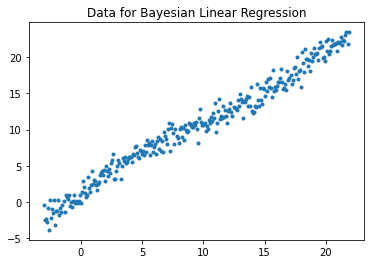

In [2]:
# Haining Tan, Jan 18 / Schwartz, Jan 21

def generate_data(n=100, sd=1, xlims=[-3,6*np.pi+3], seed=1,
                  f = lambda x: 1 + x + np.sin(x/3)*(x>0)*(x<6*np.pi)):
    '''
    This version more accurately reflects the functional relationship?
    `np.sin(x/3)*(x>0)*(x<6*np.pi))` is not intuitive feature engineering
    and without specifying this correctly the linear specification is wrong
    and subsequently the normality assumptions of the model are incorrect.

    Are you sure you want to introduce correlated errors into the analysis?
    '''

    np.random.seed(seed)
    x = np.linspace(*xlims, n)
    y = f(x) + np.random.normal(0, sd, n)
    return x,y

x, y = generate_data(300)
plt.plot(x, y, '.')
plt.title("Data for Bayesian Linear Regression")
plt.show()

---
# Analytical Bayes: (drinking and) deriving the posterior


## Haining Tan, Jan 18 (2022)
---

Assume Prior $\mathbf{w} \sim N(0, \mathbf{I})$ \\
Likelihood $p(Y|X, \mathbf{w}) = \overbrace{N(\boldsymbol{\psi}(X)\mathbf{w}, \mathbf{I})}^{\text{ah $\boldsymbol{\psi}$ -- now I see!}}$ 

\begin{align*}
\log p(\mathbf{w}| D) &= \log p(\mathbf{w}) + \log p(Y|X,\mathbf{w}) + C \\
&= -\frac{1}{2}||\mathbf{w}||^2 - \frac{1}{2}||\boldsymbol{\psi}(X)\mathbf{w} - Y||^2 + C \\
&= -\frac{1}{2} (\mathbf{w}-\mu)^TΣ^{-1}(\mathbf{w}-\mu) + C
\end{align*},

where $\Sigma^{-1} = \boldsymbol{\psi}(X)^T \boldsymbol{\psi}(X) + I$ and $\mu = (\boldsymbol{\psi}(X)^T \boldsymbol{\psi}(X) + I)^{-1}\boldsymbol{\psi}(X)^TY$

Thus the posterior of $\mathbf{w}$ is also Gaussian:
$$p(\mathbf{w}|D) = N(\mu, \Sigma)$$

In [3]:
# Schwartz, Jan 21

x, y = generate_data(1000)

# 1. Consider non-linearity

# so since f = lambda x: 1 + x + np.sin(x/3)*(x>0)*(x<6*np.pi)
nonlinear_f = lambda x: np.sin(x/3)*(x>0)*(x<6*np.pi)
psiX = np.concatenate([1+0*x[:,np.newaxis], 
                      x[:,np.newaxis], nonlinear_f(x[:,np.newaxis])],axis=1)

def analytical_post(psiX):
  post_COV = np.linalg.inv(psiX.T.dot(psiX)+np.eye(psiX.shape[1]))
  post_MU = post_COV.dot(psiX.T.dot(y))
  post_STD = np.diag(post_COV)**0.5 # posterior standard deviations

  print("posterior mean: ", post_MU)
  print("posterior std: ", post_STD)
  return post_MU, post_STD

post1_mu, post1_std = analytical_post(psiX)

posterior mean:  [1.05248924 0.99843718 1.01624549]
posterior std:  [0.05769751 0.00512674 0.05977914]


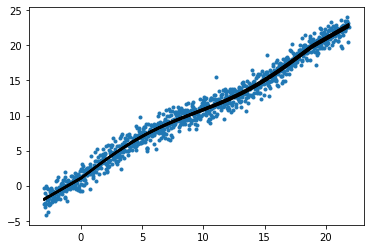

In [4]:
plt.plot(x, y, '.')
for i in range(10):
  plt.plot(x, psiX.dot(np.random.normal(post1_mu, post1_std)), 'k')

In [5]:
# 2. start from linear model

psiX = np.concatenate([1+0*x[:,np.newaxis], x[:,np.newaxis]],axis=1)
post2_mu, post2_std = analytical_post(psiX)

posterior mean:  [1.47362895 0.95370818]
posterior std:  [0.05210859 0.00440008]


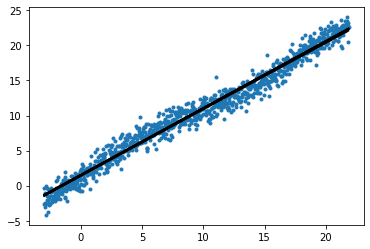

In [6]:
plt.plot(x, y, '.')
for i in range(10):
  plt.plot(x, psiX.dot(np.random.normal(post2_mu, post2_std)), 'k')

---
# Markov chain Monte Carlo (MCMC) Bayes: simulating/sampling the posterior

## Haining Tan, Feb 3 (2022) / introductory comments Schwartz May 7 (2022)
---

The automatic differentiation technology which underlies probabilistic programming tools such as PyMC3 is principally the same as the automatic differentiation technology that underlies modern neural network model fitting.  E.g., because of Google's efforts with [TensorFlow Probability](https://www.tensorflow.org/probability), [PyMC](https://docs.pymc.io/en/v3/) was [initially interested](https://pymc-devs.medium.com/theano-tensorflow-and-the-future-of-pymc-6c9987bb19d5) in transitioning from (the soon to be officially discontinued) [Theano](https://en.wikipedia.org/wiki/Theano_(software)) to [TensorFlow](https://www.tensorflow.org). However, because of subtle differences in the ways the different frameworks treat their computational graphs (e.g., see also [PyTorch](https://pytorch.org/) from Facebook and [MXNET](https://mxnet.apache.org/versions/1.9.0/) from Apache), PyMC determined that their use-case was better supported by Theano than TensorFlow. PyMC has thus adopted ownership of a stable version of Theano which adequately supports their codebase, and adopted [Jax](https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b) which allows them to convert between different computational graph frameworks once a graph is compiled. So PyMC models are in fact framework agnostic; although, they must be constructed and compiled using Theano.

- There are viable alternatives to PyMC, e.g., [Stan](https://mc-stan.org/) (based on custom proprietary automatic differentiation technology) and [Edward](http://edwardlib.org/) (which has always been based on TensorFlow), and [PYRO](https://pyro.ai) (which has been developed for PyTorch).


### Question: are there good reasons that we might consider moving our work away from TensorFlow and TensorFlow Probability?

- Are the alternatives more user friendly with better documentation?
- Do the alternatives better support Normalizing Flows (NF)?  
    - I am not fully convenced that NF are adequately supported in TensorFlow at this point, to be honest...

In [7]:
# Haining Tan, Feb 3

# MCMC sampling using PyMC3

def mc_sampling(linear=True):
  with pm.Model() as lr_model:
    
    # prior
    w = pm.Normal("slope", mu=0, sigma=1)
    b = pm.Normal("bias", mu=0, sigma=1)

    if not linear:
    # Likelihood with non-linearity
      likelihood = pm.Normal("y", mu = w*x + b + nonlinear_f(x), sigma=1, observed=y)
    else:
    # Linear model
      likelihood = pm.Normal("y", mu = w*x + b, sigma=1, observed=y)

    # posterior
    posterior = pm.sample(1000, cores=3, return_inferencedata=False)
    return posterior

def analyze_sampling(trace, analytical_mu):
  fig, ax = plt.subplots(1, 2, figsize=(14,5))
  w_samples = trace.get_values("slope")
  w_mean = w_samples.mean()
  w_std = w_samples.std()
  ax[0].hist(w_samples, bins=50)
  ax[0].axvline(w_mean, color="black", label="posterior mean")
  ax[0].axvline(analytical_mu[1], color="r", label="analytical mean")
  ax[0].axvline(w_mean - 2*w_std, color="r", linestyle='dotted')
  ax[0].axvline(w_mean + 2*w_std, color="r", linestyle='dotted')

  b_samples = trace.get_values("bias")
  b_mean = b_samples.mean()
  b_std = b_samples.std()
  ax[1].hist(b_samples, bins=50)
  ax[1].axvline(b_mean, color="black", label="posterior mean")
  ax[1].axvline(analytical_mu[0], color="r", label="analytical mean")
  ax[1].axvline(b_mean - 2*b_std, color="r", linestyle='dotted')
  ax[1].axvline(b_mean + 2*b_std, color="r", linestyle='dotted')

  ax[0].legend()
  ax[1].legend()
  plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bias, slope]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/69/4n0cxvc52gl8cvmf7qn06jr00000gn/T/ipykernel_87170/45514453.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(posterior1)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/schwarls37/opt/miniconda3/envs/STA410/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 504x504 with 0 Axes>

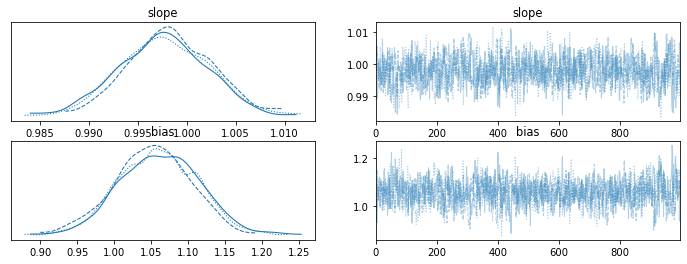

In [8]:
# 1. non-linear model
posterior1 = mc_sampling(linear=False)
plt.figure(figsize=(7,7))
pm.traceplot(posterior1)
plt.show()

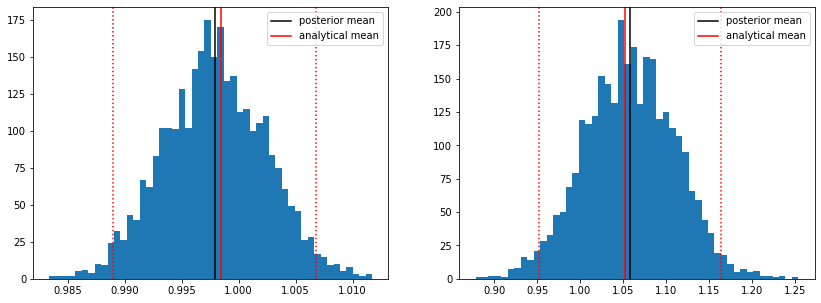

In [9]:
analyze_sampling(posterior1, post1_mu)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [bias, slope]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8850271249603754, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/69/4n0cxvc52gl8cvmf7qn06jr00000gn/T/ipykernel_87170/736818498.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(posterior2)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/schwarls37/opt/miniconda3/envs/STA410/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pym

<Figure size 504x504 with 0 Axes>

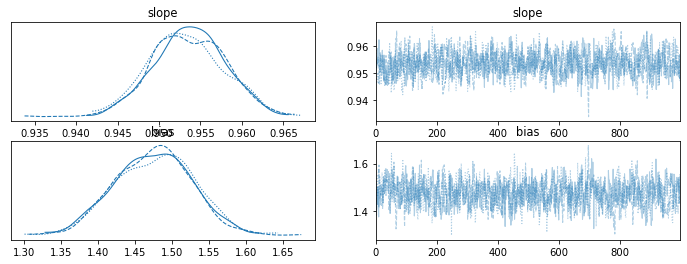

In [10]:
# 2. linear model
posterior2 = mc_sampling(linear=True)
plt.figure(figsize=(7,7))
pm.traceplot(posterior2)
plt.show()

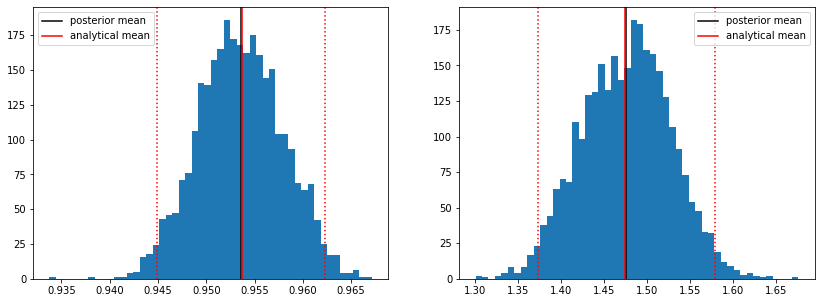

In [11]:
analyze_sampling(posterior2, post2_mu)

## Question: do the MCMC results match the analytical posterior?

| | Analytical estimate for non-linear model | Analytical estimate for linear model |
|-|-|-|
| Bias | mean = 1.05, std = 0.058 | mean = 1.47, std = 0.05 |
| Slope | mean = 1, std = 0.005 | mean = 0.95, std = 0.0044 |
| Non-linear term | mean =  1.02, std = 0.06 |

---
# Variational distributions: distribution approximation

## Schwartz Sep 22 (2021) / Haining Tan Dec 16 (2021) / Schwartz Dec 20 (2021)
---

### Section 2.4 of [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) (Kingma/Welling 2014).

This paper is concerned with embedding an observation $x$ into an unknown latent space Z, and takes a Bayesian view of the embedded object $z$; so, z is a "parameter" which can be given a (*a priori*) distribuition, and the target of interest is the updated information about $p(z|x)$.

> Notice, then, that there are a lot of posterior distribiutions $p(z_i|x_i)$, one for every observation $x_i$.

Kingma/Welling propose variational inference to approximate the posterior

\begin{align*}
\overset{prior}{p(z)} \times \overset{likelihood}{f_{\underset{decoder}{\theta(z)}}(x|z)} \propto {} &  \overset{posterior}{p(z|x)} \\
 \approx  {} &  \overset{variational}{\overset{distribution}{q_{\underset{encoder}{\theta(x)}}(z|x)}}
\end{align*}

leading to the variational inference optimization objective

$$\underset{\theta_{dec}, \theta_{enc}}{\max} \left[ E_{q_{\theta_{enc}}(z|x)}[\log f_{\theta_{dec}}(x|z)]  - \underbrace{ KL[\, q_{\theta_{enc}}(x|z) \, || \, p(z) \,]}_{E_{q_{\theta_{enc}}(z|x)}\left[\log  \frac{q_{\theta_{enc}}(z|x)}{p(z)}\right] \;\geq\; 0} \right] $$


> While I must admit this formulation is clever, I find the application of Bayesian terminology of "priors" and "posteriors" in this context to be quite the abuse of language. Specifically
> - $z$ is an embedding, which is hardly a "parameter" as far as my sensibilities are concerned: $z$ is a standard conditional prediction (which happens to be optimized on the distributional characteristics endowned upon $z$)
    - I.e., the *variational (encoder) distribution* $q_{\theta_{enc}}(z|x)$ is simply a clever way to define an optimization objective based on (theoretical probabilistic) conditional distributions $p(z_i|x_i)$ assuming some set of $p(z_i)$ specifications
        - but $p(z_i)$ are just *marginal distributions* and $p(z_i|x_i)$ are just *conditional distributions* and there is no need to refer to "prior" and "posterior" characterizations when the context is only based on the (partially observed) *joint distribution* $p(z, x)$
    - I.e., this context has no "parameters" until it is made an *unsupervised learning* specification with the introduction of the *encoder* defined by the *variational parameters* $\theta_{enc}$ 
        - and anyway, *variational parameters* defining *variational distributions* in *variational inference* are not granted priors; but, rather, are simply optimization targets.
> - Now, on the other hand, the likelihood $f(x|z,\theta_{dec})$ is a *decoder* parameterized as a neural network $\theta_{dec}(z)$, so where is the posterior on the actual parameters $\theta_{dec}$ of the neural network?  
>    - Answer: nowhere -- there is no posterior distribution on the actual parameters $\theta_{dec}$ of the *decoder* neural network becuase this is not a proper posterior analysis of the $\theta_{dec}$ parameters of the likelihood model.
        - And there was never going to be a posterior analysis on the $\theta_{enc}$ because these are variational parameters to be optimized (as opposed to given priors and a proper posterior analysis)
> 
> And that's (exactly) why I find the use of the Bayesian terminology in the context extremely disingenuous (at worst) and quite confused (at best): there is no posterior analysis of the actual parameters of the autoencoder $\theta_{enc}$ and $\theta_{dec}$.  Thus, autoencoder are not Bayesian; rather, they simply use a variational distribution based objective function to create a probabilistic encoding of unobserved latent variables. Which is cool. But is not Bayesian.

### The reparameterization trick

Pursuing the variational objective above with gradient descent is thus based on a derivative of an integral

- since the expectation and the KL-divergence term (which is also an expectation) are both integrals

and computing this derivative thus requires interchanging the order of integration and derivative, i.e.,

$$\frac{d}{d\theta} \int \cdots q_{\theta_{enc}}(z|x) d z \overset{?}{=}  \int \frac{d}{d\theta} \cdots q_{\theta_{enc}}(z|x) d z$$

The *reparameterization trick* allows this derivative-integral interchange if a change of variables transformation from independent random variables $\epsilon$, e.g., $z = \mu_x + \sigma_x \epsilon$, is available

$$\text{so } \quad z = g_x(\epsilon) \quad \text{ and } \quad q_{\theta_{enc}}(z|x) = p(\epsilon = g_x^{-1}(z) ) \frac{d g_x^{-1}(z)}{d z} \quad \Longrightarrow \quad q_{\theta_{enc}}(z|x) dz = p(\epsilon) d \epsilon $$

so that

$$\frac{d}{d\theta} \int \cdots q_{\theta_{enc}}(z|x) d z = \frac{d}{d\theta} \int \cdots p(\epsilon) d \epsilon =  \int \frac{d}{d\theta} \cdots p(\epsilon) d \epsilon$$


---
# Variational Inference (VI): posterior approximation

## Schwartz Sep 22 (2021) / Tan Dec 16 / Schwartz Dec 20 + revised May 7 (2022)
---

### Section 3.1 of [Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424) (Blundell et al. 2015).

This paper is concerned with taking a Bayesian view of the weights and biases of a neural network archetucture; so, $w$ and $b$ are parameters which can be given (*a priori*) distribuitions, and the target of interest is the updated information about $p(w,b|\mathcal{D})$, where $\mathcal{D}$ is the data used to train a neural network.

> Notice that the posterior distribution has many margins $p(w^{(h)}_{jk}|\mathcal{D})$ and $p(b^{(h)}_k|\mathcal{D})$ since there may be many hidden layers $h$ in a neural network, each with weights $w^{(h)}_{jk}$ connecting a node $j$ from a previous layer with a node $k$ in the current layer, and a bias term $b^{(h)}_k$ for each node $k$ in the current layer; and, there may be complex dependency structure within the $w_i$ and $b_i$ random variables in their true joint posterior distribution (which will also be symmetric since the parameters unidentifiable as a result if index exchangability).


Blundell et al. examine the (non linear) regression problem parameterized by $\theta \equiv (w,b)$

\begin{align*}
\overset{neural\ network}{\underset{likelihood}{f_{\theta}(y|x)} \; \times}  \underset{prior}{p(\theta|x)} 
\propto {} & \underset{posterior}{p(\theta|x,y)} \\
\approx {} & \overset{variational}{\overset{distribution}{q_\phi(\theta|x,y)}}
\end{align*}

leading to the variational inference optimization objective

$$\underset{\phi}{\max} \left[ E_{q_\phi(\theta|x,y)}[\log f_{\theta}(y|x)]  - \underbrace{ KL[\, q_\phi(\theta|x,y) \, || \, p(\theta|x) \,]}_{E_{q_\phi(\theta|x,y)}\left[\log  \frac{q_\phi(\theta|x,y)}{p(\phi|x)}\right] \;\geq\; 0} \right] $$

and again use the *reparameterization trick* (of a change of variables transformation of independent random variables) to define

$$\theta = g_\phi(\epsilon)$$

> - $\theta\equiv(w,b)$ are the parameters of interest $\phi$ are the *variational parameters* defining the *variational distribution* $q_\phi(\theta|x,y)$ which is approximating the *true posterior* $p(\theta|x,y)$ by *variational inference*.
> - The *variational inference* problem optimizes the *variational family* parameters $\phi$ with respect to the *variational inference optimization objective* so that $q_\phi(\theta|x,y) \approx p(\theta|x,y)$
>
> E.g., suppose the *mean-field variational family* $q_{\phi_j}(\theta_j|x,y) \sim N(\mu_j(x,y), \sigma_j(x,y))$ is used so 
>
> $$\theta_j = g_{\phi_j}(\epsilon) = \mu_j(x,y) + \sigma_j(x,y)\epsilon_j, \epsilon \sim N(0,1)$$
>
> Then $\phi_j \equiv (\mu_j(x,y), \sigma_j(x,y))$ and given $(x,y)$ and $\mu_j$ and $\sigma_j$ (which, e.g., could be "learned" neural networks), the only stochastic element of the specification is $\epsilon$ 
> - so the expectation can be taken with respect to $p(\epsilon)$ instead of $q_\phi(\theta|x,y)$, which then allows $\frac{\partial}{\partial \phi}$ can be taken inside of the expectation.

Since $\theta$ depends on $\phi$, the *reparameterization trick* for calculating the gradient requires the [total derivative](https://math.stackexchange.com/questions/174270/what-exactly-is-the-difference-between-a-derivative-and-a-total-derivative), and it is this formulation which results in the specification known as *Bayes by Backprop* (BBB)

\begin{align*}
\frac{\partial}{\partial \phi}E_{q_\phi(\theta|x,y)}\left[h(\phi, \theta,y,x)\right] = {} & E_{p(\epsilon)}\left[\frac{\partial h(\phi, \theta,y,x)}{\partial \theta}\frac{{\partial \theta}}{\partial \phi} + \frac{{\partial  h(\phi, \theta,y,x)}}{\partial \phi} \frac{\partial \phi}{\partial \phi}\right]\\
= {} & E_{p(\epsilon)}\left[\frac{\partial h(\phi, \theta,y,x)}{\partial \theta}\frac{{\partial \theta}}{\partial \phi} + \frac{{\partial  h(\phi, \theta,y,x)}}{\partial \phi}\right]
\end{align*}

where $h(\theta,\phi,x,y)=\log f_\theta(y|x) - \log \frac{q_\phi(\theta|x)}{p(\theta|x)}$.

---

# History of TensorFlow Probability Layers 
## Schwartz Dec 20 (2021) + revised May 7 (2022)
---

This [github issue](https://github.com/tensorflow/probability/issues/727) discusses the differences between the different `tfpl` VI implementations.
- "V1" implementations include [`tfpl.DenseReparameterization`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseReparameterization),  [`tfpl.DenseLocalReparameterization`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseLocalReparameterization), and [`tfpl.DenseFlipout`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout).
    > All of these inherit from [`_DenseVariational`](https://github.com/tensorflow/probability/blob/v0.15.0/tensorflow_probability/python/layers/dense_variational.py#L168-L187) which prescribes separate arguments for bias and kernel parameter distributions.
    > - The "V1" design of `tfp_layers_util.default_mean_field_normal_fn()`.

- The "V2" implementation is [`DenseVariational`](https://github.com/tensorflow/probability/blob/f3777158691787d3658b5e80883fe1a933d48989/tensorflow_probability/python/layers/dense_variational_v2.py#L156-L177) (as opposed to `_DenseVariational`).
   > [`DenseVariational`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseVariational) adds the `kl_weight` argument and combines the kernel and bias parameters into the same vector.
   > - The "V2" implementation is based on the updated design of `tfpl.default_mean_field_normal_fn`.

Because [KL-divergence is additive](https://math.stackexchange.com/questions/1934029/additive-property-of-kullback-liebler-divergence), the difference between the "V1" and "V2" versions is only one of usage. In terms of their potential mathematical VI specifications, they can be used equivalently and interchangably.

In [12]:
# Haining Tan Dec 16 

def neg_loglik(target, pred_distribution):
  return -pred_distribution.log_prob(target)

# KL-term corrected with kl / num_examples_per_epoch adjustment, which is independent from batch_size
def kl_div(q, p, _):
  return tfpd.kl_divergence(q, p)/x.shape[0]

In [18]:
# Haining Tan Dec 16 + Schwartz, Dec 20

# BBB approximation using full-rank Gaussian # i.e., standard multivariate normal
# An important note to keep in mind is that initializations matter a lot in neural network contexts

def create_BBB_model(linear):
    inputs = layers.Input(shape=(1,))
    BBB = tfpl.DenseReparameterization # trying out V1 
    # https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseReparameterization
    # not https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseVariational
    
    if linear:

        lm = BBB(1, activation=None,
                 kernel_divergence_fn=kl_div,
                 bias_divergence_fn=kl_div,
                 # https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseReparameterization
                 # bias_prior_fn: None (no prior, no variational inference) 
                 # bias_posterior_fn: default_mean_field_normal_fn(is_singular=True) (which creates an instance of tfd.Deterministic)      
                 # https://www.tensorflow.org/probability/api_docs/python/tfp/layers/default_mean_field_normal_fn 
                 bias_posterior_fn = tfpl.default_mean_field_normal_fn(
                     loc_initializer=tf1.initializers.random_normal(mean=1.5, stddev=1),
                     untransformed_scale_initializer=tf1.initializers.random_normal(mean=10, stddev=0.01)),
                 bias_prior_fn = tfpl.default_multivariate_normal_fn,
                 # kernel_prior_fn: tfp.layers.default_multivariate_normal_fn
                 # kernel_posterior_fn: tfp_layers_util.default_mean_field_normal_fn()    
                 kernel_posterior_fn = tfpl.default_mean_field_normal_fn(
                      loc_initializer=tf1.initializers.random_normal(mean=1, stddev=1),
                      untransformed_scale_initializer=tf1.initializers.random_normal(mean=-3, stddev=0.01))
                 )(inputs)

        # not yet in use
        features = BBB(0, activation="relu", kernel_divergence_fn=kl_div,
                       bias_divergence_fn=kl_div, # this doesn't do anything
                       bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=True,
                       loc_initializer=tf1.initializers.random_normal(mean=10, stddev=3)),
                       kernel_posterior_fn = tfpl.default_mean_field_normal_fn(
                       loc_initializer=tf1.initializers.random_normal(mean=1, stddev=.1),
                       untransformed_scale_initializer=tf1.initializers.random_normal(mean=10, stddev=0.1))
               )(inputs)

        params = layers.Concatenate(axis=1)([lm,features])
    
    else:
        # `features` and `params` could be overwritten here...
        pass



    pred_distribution = tfpl.DistributionLambda(lambda params: 
                             tfpd.Normal(loc = params[:,0:1], 
                             scale = 1))(params)#1e-3+tf.math.softplus(0.05*params[:,1:2])))(params)
    model_BBB = tf.keras.Model(inputs=inputs, outputs=pred_distribution)
    return model_BBB

model_BBB = create_BBB_model(linear=True)

/Users/schwarls37/opt/miniconda3/envs/STA410/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
2022-05-07 20:12:04.783120: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/schwarls37/opt/miniconda3/envs/STA410/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(
2022-05-07 20:12:05.209604: W tensorflow/python/util/util.cc:368] Set

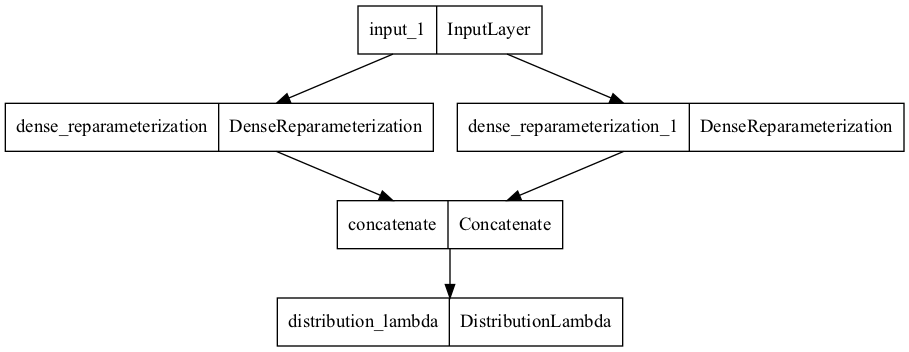

In [19]:
# Schwartz, Dec 20

keras.utils.plot_model(model_BBB)

In [20]:
# Schwartz, Dec 20

# https://www.tensorflow.org/guide/keras/custom_callback
# https://stackoverflow.com/questions/48488549/keras-append-to-logs-from-callback
class CustomErrorMonitor(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseReparameterization
    logs['kernel_kl'] = kl_div(self.model.layers[1].kernel_posterior, self.model.layers[1].kernel_prior, _).numpy()
    logs['bias_kl'] = kl_div(self.model.layers[1].bias_posterior, self.model.layers[1].bias_prior, _).numpy()
    #logs['neg_loglik'] = neg_loglik(y[:,np.newaxis], model_BBB(x)).numpy().mean()
    logs['neg_loglik'] = np.mean([neg_loglik(y[(b*32):((b+1)*32),np.newaxis], model_BBB(x[(b*32):((b+1)*32)])).numpy().mean() for b in range(int(len(x)/batch_size))])
    logs['bias'] = model_BBB.layers[1].bias_posterior.mean().numpy()[0]
    logs['bias_sd'] = model_BBB.layers[1].bias_posterior.stddev().numpy()[0]
    logs['kernel'] = model_BBB.layers[1].kernel_posterior.mean().numpy()[0][0]
    logs['kernel_sd'] = model_BBB.layers[1].kernel_posterior.stddev().numpy()[0][0]    

In [22]:
# Haining Tan Dec 16 + Schwartz, Dec 20

# takes quite a bit of time to run...

model_BBB.compile(tf.keras.optimizers.Adam(), loss=neg_loglik) 
batch_size = 32 # the default
tmp = model_BBB.fit(x, y, epochs=1000, verbose=0, # [:,np.newaxis] not needed for this version
                    batch_size=batch_size, callbacks=[CustomErrorMonitor(), 
                                                      keras.callbacks.CSVLogger('training.log')])

dict_keys(['loss', 'kernel_kl', 'bias_kl', 'neg_loglik', 'bias', 'bias_sd', 'kernel', 'kernel_sd'])

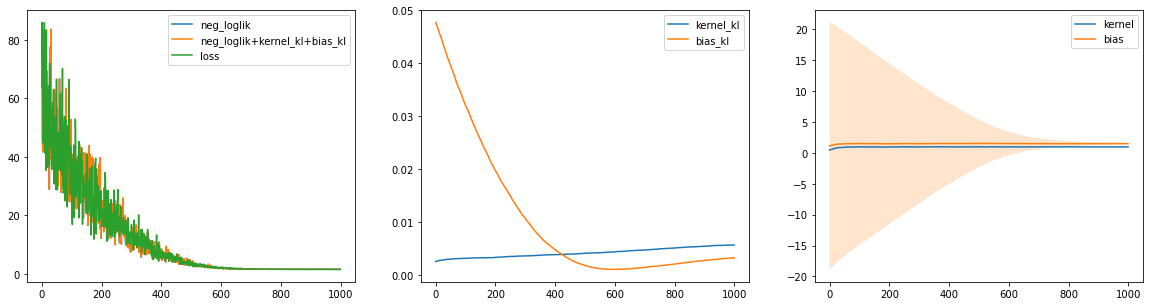

In [23]:
# Schwartz, Dec 20

fig,ax = plt.subplots(1,3, figsize=(20,5))
ax[0].plot(tmp.history['neg_loglik'], label='neg_loglik')
ax[0].plot(np.array(tmp.history['neg_loglik'])+
         np.array(tmp.history['kernel_kl'])+
         np.array(tmp.history['bias_kl']), label='neg_loglik+kernel_kl+bias_kl')
ax[0].plot(tmp.history['loss'], label='loss')
ax[0].legend()

ax[1].plot(np.array(tmp.history['kernel_kl']), label='kernel_kl')
ax[1].plot(np.array(tmp.history['bias_kl']), label='bias_kl')
ax[1].legend()

ax[2].fill_between(np.arange(0,len(tmp.history['kernel'])),
                   np.array(tmp.history['kernel'])-2*np.array(tmp.history['kernel_sd']), 
                   np.array(tmp.history['kernel'])+2*np.array(tmp.history['kernel_sd']), alpha=0.2)
ax[2].plot(tmp.history['kernel'], label='kernel')
ax[2].plot(tmp.history['bias'], label='bias')
ax[2].fill_between(np.arange(0,len(tmp.history['bias'])),
                   np.array(tmp.history['bias'])-2*np.array(tmp.history['bias_sd']), 
                   np.array(tmp.history['bias'])+2*np.array(tmp.history['bias_sd']), alpha=0.2)
ax[2].legend()
# ! head training.log
tmp.history.keys()

In [24]:
(tmp.history['bias'][-1]),tmp.history['kernel'][-1],tmp.history['bias_sd'][-1],tmp.history['kernel_sd'][-1]

(1.476252, 0.95399034, 0.067020886, 0.0031702514)

In [25]:
post2_mu, post2_std # posterior MCMC coefficients and standard deviations

(array([1.47362895, 0.95370818]), array([0.05210859, 0.00440008]))

## Question: do the VI results match the analytical posterior?

| | Analytical estimate for non-linear model | Analytical estimate for linear model |
|-|-|-|
| Bias | mean = 1.05, std = 0.058 | mean = 1.47, std = 0.05 |
| Slope | mean = 1, std = 0.005 | mean = 0.95, std = 0.0044 |
| Non-linear term | mean =  1.02, std = 0.06 |

## Question: Can we get the VI specification to learn the nonlinearity? 

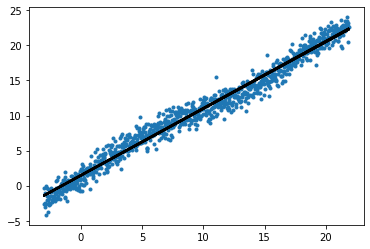

In [26]:
# Schwartz, Dec 20

#plt.plot(x, model_BBB.predict(x),'r')
plt.plot(x, y, '.')
for i in range(20):
  plt.plot(x, model_BBB(x).mean(),'k')

Text(0.5, 1.0, 'Prediction of VI model')

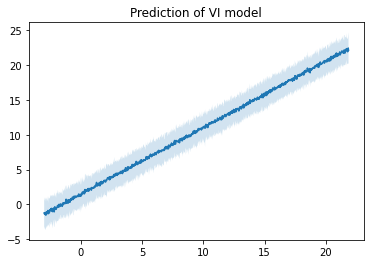

In [35]:
# Haining Tan Dec 16

x_test = x # np.arange(-10, 30, 0.3)
predictions = []
for i in range(50):
  predictions.append(model_BBB.predict(x_test)) # this samples pred_dist since
  # because default is convert_to_tensor_fn=tfp.distributions.Distribution.sample
  # https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DistributionLambda 
  # so if we're interested in characterizing uncertainty of the mean then we want
  #predictions.append(model_BBB(x_test).mean())

predictions = np.array(predictions)
mu = np.squeeze(np.mean(predictions, axis=0))
std = np.squeeze(np.std(predictions, axis=0))

#plt.plot(x, y, '.')
plt.plot(x_test, mu, label="Mean prediction")
plt.fill_between(x_test, mu - 2*std, mu + 2 * std, alpha=0.2)
plt.title("Prediction of VI model")